![Static Badge](https://img.shields.io/badge/PO.DAAC-Contribution-%20?color=grey&labelColor=blue)

> From the PO.DAAC Cookbook, to access the GitHub version of the notebook, follow [this link](https://github.com/podaac/tutorials/blob/master/notebooks/Advanced_cloud/basic_dask.ipynb).

# Basics of Xarray with Dask Parallization for Earth Data

#### *Author: Dean Henze, NASA JPL PO.DAAC*

This notebook covers the basics of using Dask for parallel computing with NASA Earth Data completely in the cloud (the data are both accessed and analyzed in the cloud).

### Brief summary of parallel computing and Dask for Earth data analysis
Briefly, parallel computing is a method which:

* Can process data sets which are larger than the RAM of a machine.
* Can reduce computation time. For example, the Macbook used to write this notebook header has multiple processors, but normal execution of Python code will not necessarily utilized the processors in parallel (e.g. split up the work across the processors simultaneously).

Dask is a Python package to utilize parallel processing. With data accessible in the Cloud this capability presents a great opportunity, since any user can spin up a virtual machine with more RAM and processors than their local machine/laptop, allowing them to magnify the benefits of parallel processing. Great introductions to parallel computing and Dask (brief yet pedagogical) are linked to in the Prerequisites section further down and a reader completely new to these concepts is encouraged to read them.

In the author's experience, many Earthdata analyses will fall into one of two categrories, and determining which one is key to set up the appropriate parallelization method. 
1. A computation which simply needs to be replicated many times, such as applying the same computation to 1000 files. The first schematic (below) shows an example for a common NASA Earthdata set format, where each file contains data for one timestamp, as well as spatial dimensions such as *x1*=latitude, *x2*=longitude. We want to apply a function *F(x1,x2)* to each file. Alternately, each file could correspond to a satellite orbit, and *x1, x2* are the satellite cross-track and along-track dimensions.

<img src="../../images/basicdask_schematic1.png" alt="sch1" width="500"/>

<br/><br/>

2. A computation which cannot trivially be replicated over multiple files, or over parts of a single file. In the example of the NASA Earthdata set, where each file corresponds to a separate time stamp, this type of parallelization challenge could correspond to taking the mean and standard deviation over time at each latitude, longitude grid point (second schematic below). In this case, data from all the files is required to compute these quantities. Another example is an empirical orthogonal function (EOF) analysis, which needs to be performed on the entire 3D dataset as it extracts key modes of variability in both the time and spatial dimensions (third schematic).

<br/><br/>

<img src="../../images/basicdask_schematic2.png" alt="sch2" width="500"/>

<img src="../../images/basicdask_schematic3.png" alt="sch3" width="500"/>

This notebook covers basic examples of both cases 1 and 2 using Dask. In two subsequent notebooks, more complex examples of each are demo'd. However, in both cases the underlying ideas covered in this notebook will be the foundation of the workflows.


### Requirements, prerequisite knowledge, learning outcomes
#### Requirements to run this notebook
* Run this notebook in an EC2 instance in us-west-2. **It is recommended to have a minimum of an m6i.4xlarge EC2 type for this demo, in order to start local clusters with the number of processors and memory per worker we used.**
* Have an Earthdata Login account.

#### Prerequisite knowledge

* Basic knowledge of the Cloud and accessing NASA Earthdata on the Cloud. If not, checkout the [NASA Earthdata Cloud Cookbook](https://nasa-openscapes.github.io/earthdata-cloud-cookbook/).
* Basic familiarity with Xarray and NumPy. Using proper syntax with these packages is important for integrating them with Dask in some cases. Here is a great [introduction by Pangeo](https://gallery.pangeo.io/repos/pangeo-data/pangeo-tutorial-gallery/xarray.html) to fundamental Xarray functionality applicable to Earth science.
* If not familiar with Dask and Parallel computing, read these two brief pages from Ryan Abernathey's book ["An Introduction to Earth and Environmental Data Science"](https://earth-env-data-science.github.io/intro.html):
  1. [Dask intro](https://earth-env-data-science.github.io/lectures/dask/intro.html)
  2. [Basic computations with Dask](https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html)

#### Learning outcomes
This notebook demonstrates two methods to parallelize analyses which access NASA Earthdata directly in the cloud. The first method is used to compute the timeseries of global mean sea surface temperatures using the Multiscale Ultrahigh Resolution (MUR) Global Foundation Sea Surface Temperature data set (a gridded SST product), https://doi.org/10.5067/GHGMR-4FJ04. The second method uses the same data set to compute a 2D spatial map of SST's at each grid point. 

In both cases the analyses are parallelized on a local cluster (e.g. using the computing power of only the specific EC2 instance spun up). This notebook does not cover using multi-node, distributed clusters (e.g. combining computing power of multiple VMs at once).  


In [1]:
import time

import earthaccess
import xarray as xr
import numpy as np

import dask
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask.array as da

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
xr.set_options( # display options for xarray objects
    display_expand_attrs=False,
    display_expand_coords=True,
    display_expand_data=True,
)

# 1. Locate data file endpoints on the cloud and open a test file

We use the `earthaccess` package for this. For both parallelization cases, we will use the same data: gridded, 0.01 degree resolution global sea surface temperature (SST) files from the `MUR-JPL-L4-GLOB-v4.1` data set (https://doi.org/10.5067/GHGMR-4FJ04).

In [4]:
earthaccess.login()

Enter your Earthdata Login username:  deanh808
Enter your Earthdata password:  ········


In [5]:
# Granule information for MUR SST data in the specified range:
granule_info = earthaccess.search_data(
    short_name="MUR-JPL-L4-GLOB-v4.1",
    temporal=("2019-01-01", "2019-12-31"),
    )

Granules found: 365


In [6]:
# And file-like objects providing the necessary endpoints for Xarray to open the data without downloading the files:
fileobjs = earthaccess.open(granule_info)

 Opening 365 granules, approx size: 187.42 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/365 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/365 [00:00<?, ?it/s]

In [7]:
granule_info[0].size() # In MB's

377.12963104248047

In [8]:
samplefile = xr.open_dataset(fileobjs[0], chunks='auto') # specify 'chunk' kwarg, to see memory sizes of arrays. 
samplefile['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 1, lat: 17999, lon: 36000)>
dask.array<open_dataset-analysed_sst, shape=(1, 17999, 36000), dtype=float32, chunksize=(1, 4092, 8188), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

In [9]:
disksize_gran = round(granule_info[0].size())
print("At " + str(disksize_gran) + " MB per file, one year's worth of data will be " + str(365*disksize_gran/1000) + " GB")

At 377 MB per file, one year's worth of data will be 137.605 GB


**This will add up quickly if we are doing multi-decadal analyses! And this isn't even counting the size increase of the arrays once actually loaded from the .nc file to memory!**

In [10]:
samplefile.close()

# 2. Parallelization use case 1: computation which is easily iterable over multiple files

The example computation used here is computing the global mean at each time stamp. Since each MUR file corresponds to one time stamp, the task is straightforward: replicate the computation once per file. 

We first define the function to replicate over each file:

In [11]:
def sstmean_1file(fileobj): # Takes a file-like object generated by earthaccess.open()
    data = xr.open_dataset(fileobj)
    return data.time.values[0], data['analysed_sst'].mean().item() # Return timestamp and mean sst.

Time the function for one file:

In [12]:
t1 = time.time()
t, sst = sstmean_1file(fileobjs[0])
print(t)
print(sst)
t2 = time.time()

2019-01-01T09:00:00.000000000
286.9242858886719


In [13]:
dt = round(t2-t1, 1)
print(
    "At " + str(dt) + " seconds per file, it would take " 
    + str(round(dt*365/3600, 1)) + " hours to process a year, and " 
    + str(round(dt*365*10/3600, 1)) + " hours to process a decade."
    )

At 22.5 seconds per file, it would take 2.3 hours to process a year, and 22.8 hours to process a decade.


(And we are doing arguably the simplest computation one can think of. What happens when we want to do complex analyses on each file?)

Now try the computation in parallel with a local cluster. Analyzing a year to a decade would still take longer than intended for this basic intro, so only a few files are processed here. However, the code can be modified as desired, and run on larger clusters for a longer time, to play around with larger computations.

Starting a local cluster is simple:

In [14]:
client = Client(n_workers=6, threads_per_worker=1)

The following lines get info about the cluster, and a link to the Dask dashboard for the cluster. The dashboard is a GUI which lets you visualize the tasks/computations being done by each worker, how much memory each worker is currently using, etc. It is not important at first to understand all the details of the dashboard, but it is nice for:
* Verifying that your computations are using the cluster. E.g. if you don't see activity on the dashboard, your computations are not utilizing the cluster
* Tracking how much memory your computations are using per worker. This can let you know if your computations require e.g. more memory per worker, or inversely if you could use more workers without running out of memory.

In [15]:
print(client.cluster)

LocalCluster(5f2555bb, 'tcp://127.0.0.1:39075', workers=6, threads=6, memory=60.88 GiB)


In [16]:
client.dashboard_link

'https://cluster-inqaz.dask.host/jupyter/proxy/8787/status'

Next, to parallelize the `sstmean_1file` function and run it on the cluster, it takes a few more lines of code:

In [17]:
sstmean_1file_parallel = delayed(sstmean_1file)

In [18]:
%%time

# Process several granules in parallel using Dask:
tasks = [sstmean_1file_parallel(fo) for fo in fileobjs[:6]]     # Sets up the computations (relatively quick)
results = da.compute(*tasks)                                    # Performs the computations (takes most of the time)

CPU times: user 1.09 s, sys: 343 ms, total: 1.43 s
Wall time: 30.1 s


In [19]:
results

((numpy.datetime64('2019-01-01T09:00:00.000000000'), 286.9242858886719),
 (numpy.datetime64('2019-01-02T09:00:00.000000000'), 286.9402160644531),
 (numpy.datetime64('2019-01-03T09:00:00.000000000'), 286.9393615722656),
 (numpy.datetime64('2019-01-04T09:00:00.000000000'), 286.9377136230469),
 (numpy.datetime64('2019-01-05T09:00:00.000000000'), 286.9449462890625),
 (numpy.datetime64('2019-01-06T09:00:00.000000000'), 286.9688415527344))

Plot results:

Text(0, 0.5, 'Global mean SST (K)')

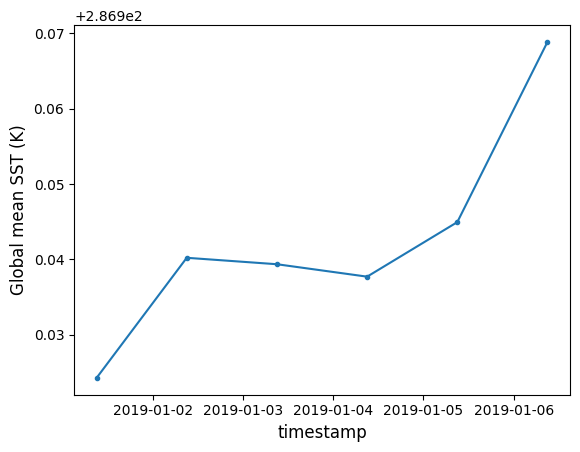

In [20]:
t, sst = list(zip(*results))

plt.plot(t, sst, '.-')
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("Global mean SST (K)", fontsize=12)

Our local cluster has processed 6 files in roughly the same amount of time as it took for 1 file earlier! We easily cut our total computation time by 6x, and can use more workers to speed this up further.

Last step is to close the cluster:

In [ ]:
dask.config.set({"distributed.admin.system-monitor.gil.enabled": False}) # Adjust settings to suppress noisy output when closing cluster
client.close()

## Other notes
* One convenience of this parallelization method that it doesn't require code to be restructured much (often times, not at all). E.g. as long as your code can be wrapped into a function, a few additional lines of code can be used to parallelize it.
* For one's own applications, figuring out how much memory their processing code requires for a single worker is important to determine how many workers can be spun up with a particular EC2 instance.
* The authors found that for local clusters, Dask seems to not manage memory optimally. For example, try running the above code with enough workers that each has ~8GB of memory, and see the memory warnings which appear. Nonetheless, the computations will finish successfully.

# 3. Parallelization use case 2: computation which is not easily iterable over multiple files

The example computation used here is the temporal mean of SST calculated at each grid point. Since each file corresponds to a timestamp, we need data accross all files to compute the mean at each grid point. Therefore, the previous parallelization method would not work well. 

## 3.1 Loading data and chunking

First, load the data for multiple timestamps into one Xarray dataset (the MUR data set is appropriately formatted, so Xarray can combine the data from multiple files along the time dimension): 

In [22]:
sstdata = xr.open_mfdataset(fileobjs[:10])
sstdata['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 10, lat: 17999, lon: 36000)>
dask.array<concatenate, shape=(10, 17999, 36000), dtype=float32, chunksize=(1, 1023, 2047), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-10T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

Xarray has also chunked the data arrays, which is important for parallel processing. The concept of chunks is covered in the prerequisite material linked to in the header, but in short they are the subsets of data that processors will work on in parallel. 

However, note that in the above chunking strategy (defaulted to by Xarray) there are 2 hang ups. First, the time dimension has a small chunk size, which is not efficient if we are looking to perform computations primarily along that axis. Second, the chunk sizes are too small - a good rule of thumb is to make chunk sizes ~100 MB. Therefore, we rechunk to something more efficient:

In [23]:
sstdata = sstdata.chunk(chunks={'lat': 1000, 'lon': 3000, 'time': 10})
sstdata['analysed_sst']

<xarray.DataArray 'analysed_sst' (time: 10, lat: 17999, lon: 36000)>
dask.array<rechunk-merge, shape=(10, 17999, 36000), dtype=float32, chunksize=(10, 1000, 3000), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-01-10T09:00:00
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Attributes: (7)

## 3.2 Computations

The above array loaded into memory is quite large (~24 GiB). Calling the following command (commented out by default) to get the temporal mean at each grid point took us a little over 5 minutes:

In [24]:
#%%time
#sstdata['analysed_sst'].mean(dim='time').compute() # Un-comment to test computation time.

However, using a local cluster speeds up the computations to under a minute (we used an m6i.4xlarge EC2 instance type). For this type of parallelization, we can start up the local cluster as in the previous section, and then run Xarray built in functions as usual, calling `compute()` at the end.

In [25]:
client = Client(n_workers=12, threads_per_worker=1)

In [26]:
print(client.cluster)
client.dashboard_link

LocalCluster(e42eb811, 'tcp://127.0.0.1:37033', workers=12, threads=12, memory=60.88 GiB)


'https://cluster-inqaz.dask.host/jupyter/proxy/8787/status'

In [27]:
%%time

meansst_2dmap = sstdata['analysed_sst'].mean(dim='time').compute()
meansst_2dmap

CPU times: user 16 s, sys: 4.06 s, total: 20.1 s
Wall time: 55.1 s


<xarray.DataArray 'analysed_sst' (lat: 17999, lon: 36000)>
array([[      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       [      nan,       nan,       nan, ...,       nan,       nan,
              nan],
       ...,
       [271.35004, 271.35004, 271.35004, ..., 271.35004, 271.35004,
        271.35004],
       [271.35004, 271.35004, 271.35004, ..., 271.35004, 271.35004,
        271.35004],
       [271.35004, 271.35004, 271.35004, ..., 271.35004, 271.35004,
        271.35004]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.99 -89.98 -89.97 -89.96 ... 89.97 89.98 89.99
  * lon      (lon) float32 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0

Plot a subset of the mean map:

Text(0.5, 1.0, 'Mean SST off the east coast of the U.S.')

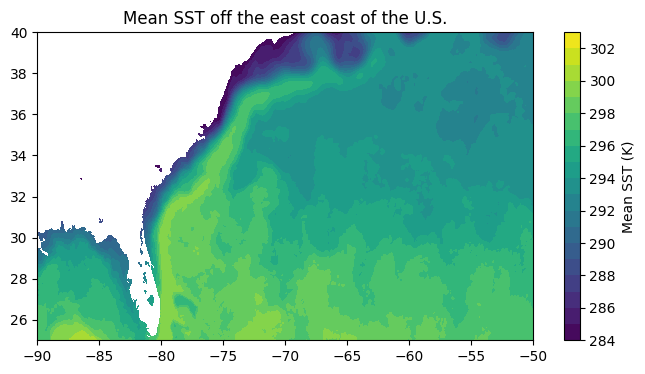

In [28]:
sub = meansst_2dmap.sel(lat=slice(25, 40), lon=slice(-90, -50))

plt.figure(figsize=(8,4))
plt.contourf(sub['lon'], sub['lat'], sub.values, levels=np.arange(284, 304, 1))
plt.colorbar(label="Mean SST (K)")
plt.title("Mean SST off the east coast of the U.S.")

In [29]:
dask.config.set({"distributed.admin.system-monitor.gil.enabled": False}) # Adjust settings to suppress noisy output when closing cluster
client.close()

In [30]:
sstdata.close()

## Other notes
* This method requires code to be written in a specific way, typically utilizing NumPy and Xarray. That is, one cannot start up a cluster and expect an arbitrarily written block of code to work in parallel on the cluster. For example, in the computation above, we used an Xarray built-in function, which is already set up to work with clusters. In general, for many Earthdata researchers starting with Dask, the following plan of attack is beneficial:
  1. See if the computation you want to perform can be done with an Xarray built-in function, all of which should work with Dask.
  2. If there is no Xarray built-in function, look for a built-in function in another library such as NumPy or SciPy (or a library built on top of these), and read the docs to check whether the function was intended to work with Dask. Generally, NumPy functions should work. SciPy functions are hit or miss in the author's experience.
  3. If no built-in function can be found, write your own function using Dask Arrays which are an extension of NumPy arrays. Tutorials on working with Dask Arrays can be found elsewhere.
* Chunking can have a significant effect on performance. Here are additional notes on chunking from the Dask documentation: https://docs.dask.org/en/latest/array-chunks.html
* It turns out that the majority of time is spent opening/locating/streaming the data within the files - comparatively little time is spent actually computing the mean. We can make our computations even faster if we have more efficient access to the data, e.g. using kerchunk, which is covered elsewhere.
